In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

#### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

#### 2. Оцените ошибку модели из п.1.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
d_data=data.resample('D').mean()
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
data_exp = pd.DataFrame(data = data_exp_1, index = d_data.index)
data_exp.rename(columns={0: 'exp_value'}, inplace=True)
data_exp.head()

,exp_value
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [5]:
df= pd.DataFrame(data_exp)
df.head()

,exp_value
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


In [6]:
#df= pd.DataFrame(data_exp)
#df.head()
#df = data_exp.copy()
 # добавили историю на глубину 3 измерения от текущего (р=3)
data_exp['t'] = 0
data_exp.iloc[1:,1]=data_exp.iloc[:-1,0].values
data_exp['t1']=0
data_exp.iloc[2:,2]=data_exp.iloc[:-2,0].values
data_exp['t2']=0
data_exp.iloc[3:,3]=data_exp.iloc[:-3,0].values
data_exp.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
data_exp['exp_0_01'] = exponential_smoothing(data_exp['exp_value'], 0.01)
#df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
#df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
data_exp['diff1'] = 0
data_exp['diff1'].iloc[1:] = data_exp.iloc[1:,0].values-data_exp.iloc[:-1,0].values

data_exp.head()

c:\users\root\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,exp_value,t,t1,t2,exp_0_01,diff1
Date,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,-55.693138


In [7]:
data_exp.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Date', length=6059, freq='D')

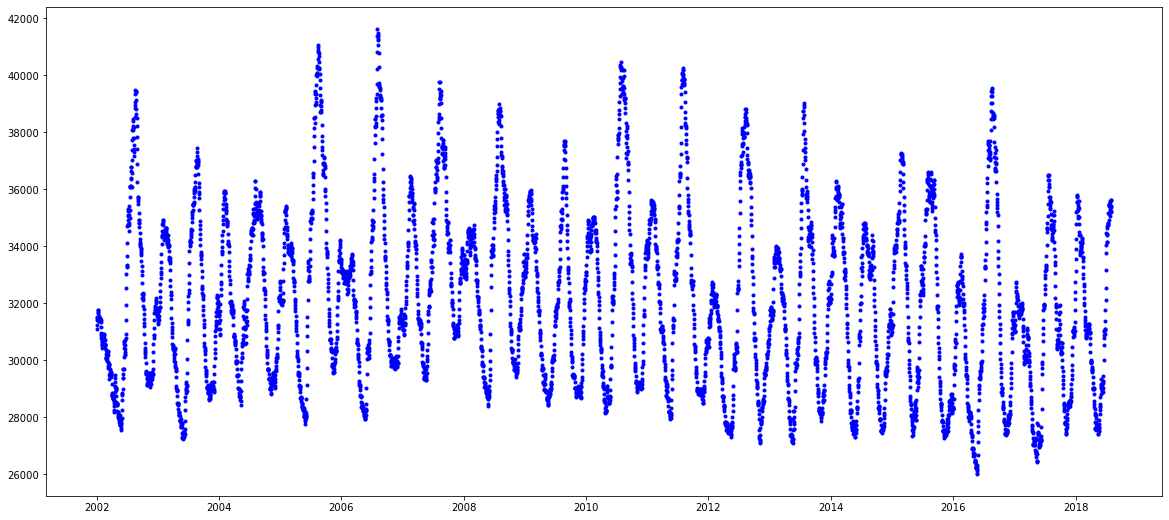

In [8]:
plt.figure(figsize=(20, 9))
plt.plot(data_exp['exp_value'], '.b')

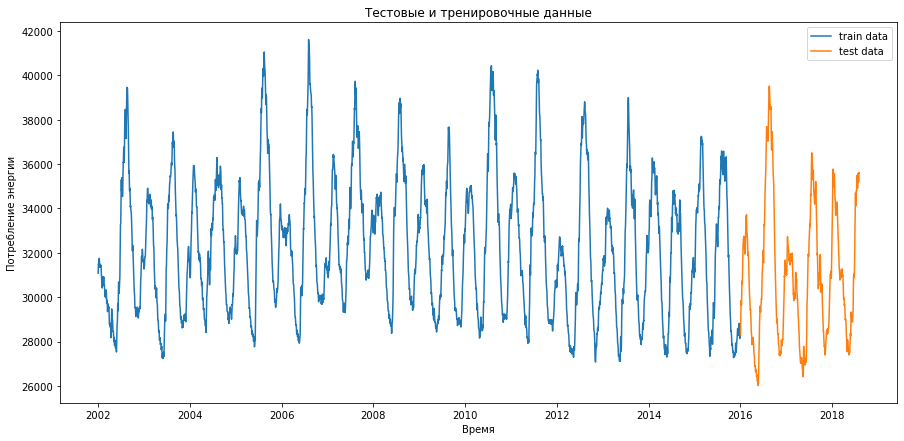

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

h= 1 # горизонт прогноза
train_b, test_b = split_data_b(data_exp, '01-01-2016')

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[data_exp.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[data_exp.columns[0]].values[h:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train_b.index,train_b[data_exp.columns[0]], label='train data' )
plt.plot(test_b.index, test_b[data_exp.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

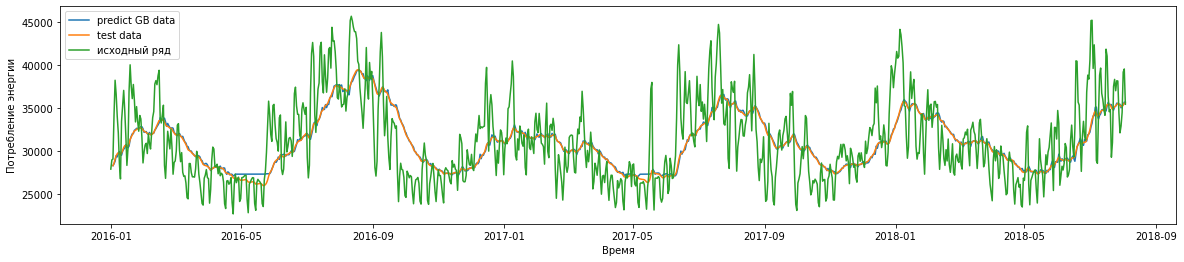

In [32]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_h1 = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_h1, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(d_data.loc['01-01-2016':].index, d_data.loc['01-01-2016':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

error_h1 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_h1)

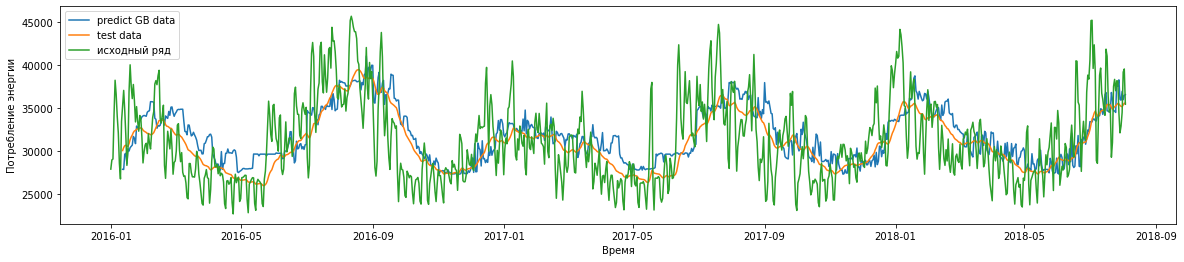

In [34]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_h10 = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_h10, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(d_data.loc['01-01-2016':].index, d_data.loc['01-01-2016':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

error_h10 = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_h10)

#### 2. Оцените ошибку модели из п.1.

In [35]:
print('ошибка градиентного бустинга для модели с h=1:  ', error_h1, '%')
print('ошибка градиентного бустинга для модели с h=10:  ', error_h10, '%')

ошибка градиентного бустинга для модели с h=1:   0.5517286089176413 %
ошибка градиентного бустинга для модели с h=10:   4.104813355268934 %


#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка модели предсказания с горизонтом h=1 (то есть наибольшая глубина истории, 1 шаг) составила 0.55 %. В то же время ошибка модели с горизонтом событий h = 10 составила 4.1 %. Делаем вывод, что история играет важную роль в предсказании временных рядов. Однако, нужно применять специальные методы для выяснения, насколько можно сгладить линию предсказаний и какую допустить глубину горизонта при большом объеме данных.

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

Ответы.

а) Определенно на лицо сезонность, так как погода сильно связана со временем года. Времена года повторяются с определенным периодом - следовательно, сезонность.

б) Нестационарный ряд. Хотя если магазин определенный, если у магазина есть стратегия на потребителя, то возможен тренд, мне кажется.

в) Определенно нестационарный ряд, так как вес котенка зависит от времени (чем дальше, тем больше, пока растет).

г) Вообще сложно. Возможно, есть сезонность (по весне начинают прорастать новые ростки и растут в лето). Еще должен быть общая взаимосвязь (тренд?) в соответствии с климатической и экологической обстановкой Земли и конкретно этого района.

#### 5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

1 ряд слева направо: 2-ой ряд, возможно, но скорее всего, он имеет непостоянную дисперсию.

2 ряд слева направо: 1-й ряд (так как по графику можно предположить постоянство математического ожидания, дисперсии и независимость от времени = ковариация постоянна).

3 ряд слева направо: 2-й ряд (хотя здесь может быть также непостоянна дисперися, но этот ряд наиболее похож на стационарный).